# Practica Machine Learning

## Preparación de datos

In [1]:
#Librerías y dependencias necesarias

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb

In [2]:
# Cargamos los datos
df = pd.read_csv('airbnb-listings.csv', sep=";")

# Nos quedamos sólo con los datos de Madrid
df = df[df['City'] == 'Madrid']

In [3]:
df.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

In [4]:
# Eliminamos las colunas que no necesitamos: bien porque son url, porue son descriptivas no caegoricas, 
# porque el numero de valores que no son na es tan pequeño que no se podrían rellenar el resto fiablemente
# o que son de lugar y se refierne solo a Madrid porque es la zona hasta donde vamos a acotar nuestros 
# datos
df= df.drop(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Location',
       'Host About','Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url', 
       'Host Verifications', 'City', 'State', 'Market', 'Smart Location', 'Country Code',
       'Country', 'Amenities', 'Has Availability', 'Calendar last Scraped',
       'License', 'Jurisdiction Names', 'Geolocation', 'Street', 'Monthly Price'], axis=1)

In [5]:
datacol = 'Reviews per Month'
print(df[datacol].dtypes)
print('--------------------------------------')
print(df[datacol].count())
print('--------------------------------------')
print(df[datacol].describe())
print('--------------------------------------')
print(df[datacol].unique())
print('--------------------------------------')
print(df[datacol].head())


float64
--------------------------------------
10494
--------------------------------------
count    10494.000000
mean         1.923459
std          1.889633
min          0.020000
25%          0.480000
50%          1.270000
75%          2.880000
max         17.210000
Name: Reviews per Month, dtype: float64
--------------------------------------
[ 5.11  5.88  6.18  0.19  1.39  0.62  0.33  0.22  0.49  0.12  1.31   nan
  4.44  0.39  4.07  3.78  1.33  0.66  0.36  2.57  1.5   2.12  4.34  3.47
  0.21  3.77  2.02  5.23  4.01  4.4   0.42  1.43  0.05  2.09  0.04  0.67
  2.14  0.56  0.73  2.79  2.4   5.04  0.29  2.32  7.2   6.21  2.17  3.92
  4.13  1.59  7.61  0.71  0.58  1.21  0.84  3.8   7.91  2.44  3.6   9.31
  2.89  1.4   0.83  0.96  2.23  2.69  1.28  9.83  2.    4.43  3.67  3.68
  3.76  2.56  0.08  7.57  3.21  3.66  2.86  1.95  1.19  6.19  2.88  1.48
  1.    1.14  3.85  0.89  1.22  2.75  5.43  0.13  3.84  1.38  5.81  0.3
  2.87  0.07  1.97  4.06  2.07  6.14  4.29  0.75  0.72  7.04  2.3   1.

In [6]:
#Añadimos variables

#Pasamos la variable a tipo de dato datatime
df['Host Since'] = pd.to_datetime(df['Host Since'])
df['First Review'] = pd.to_datetime(df['First Review'])
df['Last Review'] = pd.to_datetime(df['Last Review'])

#Nos quedamos sólo con el año
df['Host Since'] = df['Host Since'].dt.year
df['First Review'] = df['First Review'].dt.year
df['Last Review'] = df['Last Review'].dt.year

# Pasamos la columna 'Square Feet' a metros cuadrados
df['Square Meters'] = df['Square Feet'] * 0.092903

df['Host During']       = 2023 - df['Host Since']
df['First Review Ago']  = 2023 - df['First Review']
df['Last Review Ago']   = 2023 - df['Last Review']
df['Bed_Bath_rooms']    = df['Bedrooms']*df['Bathrooms']
df['Log_Square_Meters'] = df['Square Meters'].apply(lambda x: np.log(x))

df = df.drop(['Host Since', 'First Review', 'Last Review', 'Square Feet'], axis=1)

In [7]:
# Lista de nombres de las variables categóricas a codificar
categorical_variables = ['Neighbourhood', 'Host Response Time', 'Host Neighbourhood',
                         'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed','Calendar Updated',
                         'Features', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy', 'Zipcode']

# Crear una instancia de LabelEncoder para cada variable categórica
label_encoders = {}
for variable in categorical_variables:
    label_encoders[variable] = LabelEncoder()

# Ajustar y transformar los valores de cada columna categórica
for variable in categorical_variables:
    encoded_values = label_encoders[variable].fit_transform(df[variable])
    df[variable] = encoded_values

In [8]:
#Eliminar las filas donde el precio, que sera nuestra variable y sea NaN
df = df.dropna(subset=['Price'])

In [9]:
# Identificamos la variable objetivo y dovidimos entre train y test
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [10]:
X_test.isnull().sum()

Host Response Time                   0
Host Response Rate                 314
Host Neighbourhood                   0
Host Listings Count                  0
Host Total Listings Count            0
Neighbourhood                        0
Neighbourhood Cleansed               0
Neighbourhood Group Cleansed         0
Zipcode                              0
Latitude                             0
Longitude                            0
Property Type                        0
Room Type                            0
Accommodates                         0
Bathrooms                           15
Bedrooms                             5
Beds                                14
Bed Type                             0
Weekly Price                      1991
Security Deposit                  1508
Cleaning Fee                      1087
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Calendar Updated         

## Análisis exploratorio

In [11]:
df.head().T

,0,1,2,3,4
Host Response Time,3.000000,3.000000,3.000000,2.000000,3.000000
Host Response Rate,100.000000,100.000000,100.000000,100.000000,100.000000
Host Neighbourhood,109.000000,53.000000,109.000000,40.000000,40.000000
Host Listings Count,2.000000,13.000000,1.000000,3.000000,1.000000
Host Total Listings Count,2.000000,13.000000,1.000000,3.000000,1.000000
Neighbourhood,65.000000,65.000000,65.000000,25.000000,25.000000
Neighbourhood Cleansed,48.000000,48.000000,48.000000,48.000000,48.000000
Neighbourhood Group Cleansed,3.000000,3.000000,3.000000,3.000000,3.000000
Zipcode,14.000000,21.000000,21.000000,21.000000,21.000000
Latitude,40.407453,40.408316,40.413722,40.411263,40.412556


In [12]:
df.describe()

C:\Users\34697\anaconda3\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Zipcode,Latitude,...,Cancellation Policy,Calculated host listings count,Reviews per Month,Features,Square Meters,Host During,First Review Ago,Last Review Ago,Bed_Bath_rooms,Log_Square_Meters
count,13198.000000,11545.000000,13198.000000,13195.000000,13195.000000,13198.000000,13198.000000,13198.000000,13198.000000,13198.000000,...,13198.000000,13198.000000,10491.000000,13198.000000,518.000000,13195.000000,10491.000000,10490.000000,13127.000000,518.000000
mean,2.632975,94.838718,69.041521,9.817128,9.817128,44.724276,68.635854,5.686468,25.861343,40.420547,...,1.058266,7.662070,1.923690,13.912411,34.867321,8.695263,7.619293,6.331268,1.828483,-inf
std,0.913727,15.201601,34.115742,27.586541,27.586541,19.560128,33.513732,4.738686,15.670874,0.020037,...,0.836583,19.701702,1.889748,12.828462,50.525420,1.626148,1.215779,0.604733,2.474086,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,40.331888,...,0.000000,1.000000,0.020000,0.000000,0.000000,6.000000,6.000000,6.000000,0.000000,-inf
25%,2.000000,100.000000,40.000000,1.000000,1.000000,30.000000,48.000000,3.000000,14.000000,40.410073,...,0.000000,1.000000,0.480000,1.000000,0.000000,7.000000,7.000000,6.000000,1.000000,NaN
50%,3.000000,100.000000,72.000000,2.000000,2.000000,47.000000,62.000000,3.000000,21.000000,40.418644,...,1.000000,2.000000,1.270000,16.000000,10.033524,8.000000,7.000000,6.000000,1.000000,2.305932
75%,3.000000,100.000000,107.000000,5.000000,5.000000,65.000000,104.000000,8.000000,28.000000,40.427789,...,2.000000,4.000000,2.880000,24.000000,60.015338,10.000000,8.000000,7.000000,2.000000,4.094600
max,4.000000,100.000000,109.000000,265.000000,265.000000,65.000000,124.000000,20.000000,76.000000,40.514247,...,4.000000,145.000000,17.210000,59.000000,480.029801,14.000000,13.000000,11.000000,65.000000,6.173848


In [13]:
df.head()

,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Zipcode,Latitude,...,Cancellation Policy,Calculated host listings count,Reviews per Month,Features,Square Meters,Host During,First Review Ago,Last Review Ago,Bed_Bath_rooms,Log_Square_Meters
0,3,100.0,109,2.0,2.0,65,48,3,14,40.407453,...,1,2.0,5.11,40,NaN,7.0,7.0,6.0,0.0,NaN
1,3,100.0,53,13.0,13.0,65,48,3,21,40.408316,...,2,13.0,5.88,9,NaN,10.0,8.0,6.0,1.0,NaN
2,3,100.0,109,1.0,1.0,65,48,3,21,40.413722,...,1,1.0,6.18,9,NaN,6.0,6.0,6.0,1.5,NaN
3,2,100.0,40,3.0,3.0,25,48,3,21,40.411263,...,2,3.0,0.19,0,NaN,11.0,9.0,7.0,1.0,NaN
4,3,100.0,40,1.0,1.0,25,48,3,21,40.412556,...,2,1.0,1.39,31,NaN,11.0,10.0,6.0,2.0,NaN


In [14]:
df.dtypes

Host Response Time                  int32
Host Response Rate                float64
Host Neighbourhood                  int32
Host Listings Count               float64
Host Total Listings Count         float64
Neighbourhood                       int32
Neighbourhood Cleansed              int32
Neighbourhood Group Cleansed        int32
Zipcode                             int32
Latitude                          float64
Longitude                         float64
Property Type                       int32
Room Type                           int32
Accommodates                        int64
Bathrooms                         float64
Bedrooms                          float64
Beds                              float64
Bed Type                            int32
Price                             float64
Weekly Price                      float64
Security Deposit                  float64
Cleaning Fee                      float64
Guests Included                     int64
Extra People                      

In [15]:
df.columns

Index(['Host Response Time', 'Host Response Rate', 'Host Neighbourhood',
       'Host Listings Count', 'Host Total Listings Count', 'Neighbourhood',
       'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'Zipcode',
       'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Accommodates',
       'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Price', 'Weekly Price',
       'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Calendar Updated',
       'Availability 30', 'Availability 60', 'Availability 90',
       'Availability 365', 'Number of Reviews', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value', 'Cancellation Policy',
       'Calculated host listings count', 'Reviews per Month', 'Features',
       'Square Meters', 'Host During', 'First Review Ago', 'Last 

### Outlier

<AxesSubplot:ylabel='Frequency'>

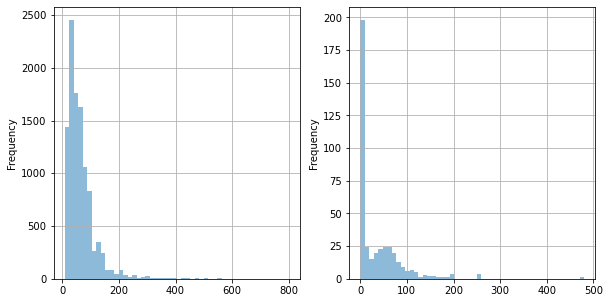

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
y_train.plot.hist(alpha=0.5, bins=50, grid = True)

plt.subplot(1,3,3)
X_train['Square Meters'].plot.hist(alpha=0.5, bins=50, grid = True)


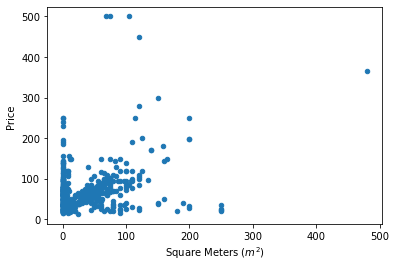

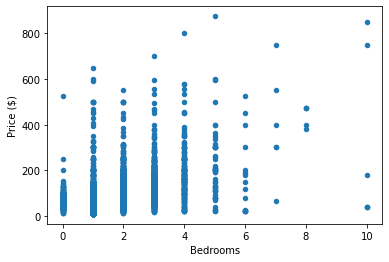

In [17]:
df.plot(kind = 'scatter',x='Square Meters',y = 'Price')
plt.xlabel('Square Meters ($m^2$)')
plt.ylabel('Price ')
plt.show()

df.plot(kind = 'scatter',x='Bedrooms',y = 'Price')
plt.xlabel('Bedrooms')
plt.ylabel('Price ($)')
plt.show()

In [18]:
X_train

,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Zipcode,Latitude,...,Cancellation Policy,Calculated host listings count,Reviews per Month,Features,Square Meters,Host During,First Review Ago,Last Review Ago,Bed_Bath_rooms,Log_Square_Meters
9948,3,100.0,46,3.0,3.0,28,86,7,44,40.483370,...,2,3.0,0.55,1,NaN,9.0,8.0,7.0,1.0,NaN
7646,1,100.0,53,1.0,1.0,34,81,8,52,40.454981,...,1,1.0,0.09,0,NaN,10.0,8.0,7.0,1.0,NaN
4766,3,100.0,40,20.0,20.0,25,48,3,21,40.410993,...,1,20.0,1.82,1,NaN,10.0,8.0,6.0,0.0,NaN
1158,3,100.0,65,142.0,142.0,65,97,14,8,40.427099,...,2,77.0,NaN,9,NaN,11.0,NaN,NaN,16.0,NaN
2629,3,100.0,49,11.0,11.0,40,80,3,14,40.411821,...,2,11.0,0.22,1,44.965052,12.0,11.0,7.0,2.0,3.805886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13291,3,100.0,7,12.0,12.0,7,16,10,17,40.424623,...,1,7.0,3.36,1,NaN,10.0,10.0,6.0,2.0,NaN
5831,4,NaN,72,1.0,1.0,43,114,3,13,40.424210,...,2,1.0,0.07,0,NaN,9.0,7.0,7.0,1.0,NaN
6048,2,100.0,109,1.0,1.0,65,48,3,14,40.407491,...,1,1.0,4.11,39,NaN,7.0,7.0,6.0,1.0,NaN
920,2,83.0,40,1.0,1.0,25,48,3,21,40.410442,...,1,1.0,2.72,31,NaN,10.0,8.0,6.0,3.0,NaN


In [19]:
# Eliminar los valores entre 20 y 250 de la columna 'Square Meters'
#y_train = y_train[(X_train["Square Meters"] < 20) | (X_train["Square Meters"] > 250)]
#X_train = X_train.drop(X_train[(X_train['Square Meters'] >= 20) & (X_train['Square Meters'] <= 250)].index)

In [20]:
y_train

9948      21.0
7646      67.0
4766      50.0
1158     556.0
2629      70.0
         ...  
13291     70.0
5831      60.0
6048      39.0
920      100.0
8127      28.0
Name: Price, Length: 10558, dtype: float64

### Correlación

In [21]:
X_train.corr()

,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Zipcode,Latitude,...,Cancellation Policy,Calculated host listings count,Reviews per Month,Features,Square Meters,Host During,First Review Ago,Last Review Ago,Bed_Bath_rooms,Log_Square_Meters
Host Response Time,1.000000,0.601773,-0.004707,-0.033281,-0.033281,-0.001957,0.028872,-0.038668,-0.030985,-0.045253,...,-0.021534,-0.048379,0.195645,0.002129,0.032800,-0.040910,-0.037832,-0.044241,-0.023156,-0.045857
Host Response Rate,0.601773,1.000000,-0.067859,-0.047868,-0.047868,-0.026884,0.016406,-0.041210,-0.054761,-0.039116,...,0.069116,-0.071223,0.192068,-0.016531,0.034075,0.037895,0.000784,-0.216128,0.001012,0.087838
Host Neighbourhood,-0.004707,-0.067859,1.000000,-0.041872,-0.041872,0.780011,0.290753,0.019048,0.079287,-0.068881,...,-0.039709,-0.043141,0.020996,0.198622,0.004586,-0.144943,-0.131220,-0.030227,-0.032316,0.244287
Host Listings Count,-0.033281,-0.047868,-0.041872,1.000000,1.000000,-0.046248,0.029394,-0.030580,-0.085017,0.009939,...,0.247044,0.924683,-0.126239,-0.106023,-0.082602,0.066271,-0.008943,0.111333,0.110365,-0.354485
Host Total Listings Count,-0.033281,-0.047868,-0.041872,1.000000,1.000000,-0.046248,0.029394,-0.030580,-0.085017,0.009939,...,0.247044,0.924683,-0.126239,-0.106023,-0.082602,0.066271,-0.008943,0.111333,0.110365,-0.354485
Neighbourhood,-0.001957,-0.026884,0.780011,-0.046248,-0.046248,1.000000,0.341743,-0.003306,0.105233,-0.064364,...,-0.013665,-0.056978,0.035492,0.207848,0.016442,-0.109586,-0.151047,-0.052023,-0.014166,0.096932
Neighbourhood Cleansed,0.028872,0.016406,0.290753,0.029394,0.029394,0.341743,1.000000,-0.165311,-0.100305,0.039799,...,0.062119,0.027292,0.029915,-0.018177,0.015844,0.038012,0.050191,-0.018072,0.010406,0.084445
Neighbourhood Group Cleansed,-0.038668,-0.041210,0.019048,-0.030580,-0.030580,-0.003306,-0.165311,1.000000,0.200247,0.137025,...,-0.063405,-0.035198,-0.140242,-0.001272,0.112907,-0.058831,-0.072045,0.050487,0.019412,0.081729
Zipcode,-0.030985,-0.054761,0.079287,-0.085017,-0.085017,0.105233,-0.100305,0.200247,1.000000,0.053480,...,-0.131270,-0.087485,-0.065482,0.061282,-0.047696,-0.097660,-0.094566,0.019022,-0.020959,-0.055515
Latitude,-0.045253,-0.039116,-0.068881,0.009939,0.009939,-0.064364,0.039799,0.137025,0.053480,1.000000,...,-0.033779,0.013664,-0.068624,-0.009154,0.106347,0.018127,-0.007974,0.036789,0.045618,0.197781


C:\Users\34697\AppData\Local\Temp\ipykernel_21780\343679108.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


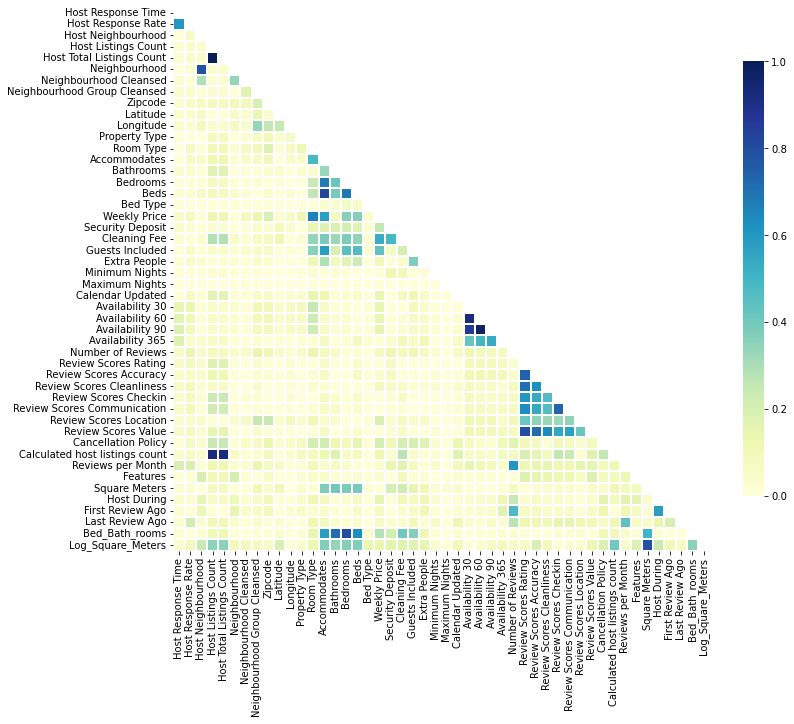

In [22]:
# Compute the correlation matrix
corr = np.abs(X_train.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [23]:
#pd.plotting.scatter_matrix(X, alpha=0.2, figsize=(20, 20), diagonal = 'hist')
plt.show()

In [24]:
y_train

9948      21.0
7646      67.0
4766      50.0
1158     556.0
2629      70.0
         ...  
13291     70.0
5831      60.0
6048      39.0
920      100.0
8127      28.0
Name: Price, Length: 10558, dtype: float64

In [25]:
# Eliminamos las variables con una alta correlación del conjunto de test y train
drop_values = ['Host Listings Count', 'Host Total Listings Count', 'Availability 30', 'Availability 60',
              'Review Scores Rating', 'Accommodates', 'Bedrooms', 'Square Meters', 'Host Neighbourhood']

X_train = X_train.drop(drop_values, axis=1)
X_test = X_test.drop(drop_values, axis=1)

## Preprocesamiento

In [26]:
# Porcentaje de valores que no son NaN de las columnas
column_percentages = X_train.count() / len(X_train) * 100

# Imprimir los resultados
print(column_percentages)

Host Response Time                100.000000
Host Response Rate                 87.317674
Neighbourhood                     100.000000
Neighbourhood Cleansed            100.000000
Neighbourhood Group Cleansed      100.000000
Zipcode                           100.000000
Latitude                          100.000000
Longitude                         100.000000
Property Type                     100.000000
Room Type                         100.000000
Bathrooms                          99.687441
Beds                               99.677969
Bed Type                          100.000000
Weekly Price                       25.554082
Security Deposit                   42.631180
Cleaning Fee                       59.310475
Guests Included                   100.000000
Extra People                      100.000000
Minimum Nights                    100.000000
Maximum Nights                    100.000000
Calendar Updated                  100.000000
Availability 90                   100.000000
Availabili

In [27]:
X_train.count()

Host Response Time                10558
Host Response Rate                 9219
Neighbourhood                     10558
Neighbourhood Cleansed            10558
Neighbourhood Group Cleansed      10558
Zipcode                           10558
Latitude                          10558
Longitude                         10558
Property Type                     10558
Room Type                         10558
Bathrooms                         10525
Beds                              10524
Bed Type                          10558
Weekly Price                       2698
Security Deposit                   4501
Cleaning Fee                       6262
Guests Included                   10558
Extra People                      10558
Minimum Nights                    10558
Maximum Nights                    10558
Calendar Updated                  10558
Availability 90                   10558
Availability 365                  10558
Number of Reviews                 10558
Review Scores Accuracy             8280


In [28]:

from sklearn.impute import SimpleImputer
# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
# Aplicar transformación para eliminar los valores infinitos
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# Lista de columnas a imputar
columns_to_impute = ['Host Response Rate',
                     'Bathrooms', 'Beds', 'Weekly Price', 'Security Deposit', 'Cleaning Fee', 
                     'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
                     'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 
                     'Reviews per Month', 'Host During', 'First Review Ago', 'Last Review Ago', 
                     'Bed_Bath_rooms', 'Log_Square_Meters']

# Imputar los valores faltantes en cada columna
for column in columns_to_impute:
    X_train[column] = imputer.fit_transform(X_train[[column]])


In [29]:
from sklearn.preprocessing import StandardScaler
# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled = pd.DataFrame(X_train, columns=X_train.columns)

In [30]:
X_scaled.describe

<bound method NDFrame.describe of        Host Response Time  Host Response Rate  Neighbourhood  \
9948                    3          100.000000             28   
7646                    1          100.000000             34   
4766                    3          100.000000             25   
1158                    3          100.000000             65   
2629                    3          100.000000             40   
...                   ...                 ...            ...   
13291                   3          100.000000              7   
5831                    4           94.895325             43   
6048                    2          100.000000             65   
920                     2           83.000000             25   
8127                    4           94.895325             40   

       Neighbourhood Cleansed  Neighbourhood Group Cleansed  Zipcode  \
9948                       86                             7       44   
7646                       81                        

In [31]:
import numpy as np
from sklearn.feature_selection import f_regression, mutual_info_regression

# convertimos el DataFrame al formato necesario para scikit-learn
data = X_train.values 

dy = y_train    # nos quedamos con la 1ª columna, price
dX = X_train      # nos quedamos con el resto

feature_names = X_train.columns[1:]

f_test, _ = f_regression(dX, dy)
f_test /= np.max(f_test)

mi = mutual_info_regression(dX, dy)
mi /= np.max(mi)



## Modelado

In [32]:
# Crear una instancia del modelo Lasso
lasso = Lasso(alpha=0.1)

# Ajustar el modelo Lasso a los datos de entrenamiento
lasso.fit(X_train, y_train)

# Obtener los coeficientes seleccionados por Lasso
lasso_coefs = lasso.coef_

# Obtener el índice de los coeficientes no nulos
selected_features = lasso_coefs != 0

# Filtrar las características seleccionadas en los conjuntos de entrenamiento y prueba
X_train = X_train.loc[:, selected_features]
X_test = X_test.loc[:, selected_features]

In [33]:
X_test.isnull().sum()


Host Response Time                   0
Host Response Rate                 314
Neighbourhood                        0
Neighbourhood Cleansed               0
Neighbourhood Group Cleansed         0
Zipcode                              0
Property Type                        0
Room Type                            0
Bathrooms                           15
Beds                                14
Weekly Price                      1991
Security Deposit                  1508
Cleaning Fee                      1087
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Calendar Updated                     0
Availability 90                      0
Availability 365                     0
Number of Reviews                    0
Review Scores Accuracy             572
Review Scores Cleanliness          569
Review Scores Checkin              572
Review Scores Communication        570
Review Scores Location   

In [34]:
# Eliminar filas con valores nulos en X_test
X_test = X_test.dropna()

# Eliminar filas correspondientes en y_test
y_test = y_test[X_test.index]


In [35]:
# Entrenar y evaluar modelos utilizando validación cruzada
models = [
    LinearRegression(),
    xgb.XGBRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
]

for model in models:
    # Entrenar con validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse_scores = -cv_scores
    average_cv_rmse = cv_rmse_scores.mean()
    
    print(f"Modelo: {model.__class__.__name__}")
    print(f"RMSE promedio (validación cruzada): {average_cv_rmse}")
    
    # Entrenar con conjunto de entrenamiento y evaluar con conjunto de prueba
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print(f"RMSE (conjunto de prueba): {test_rmse}\n")
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"R^2: {r2}")
    print()

Modelo: LinearRegression
RMSE promedio (validación cruzada): 1407.1945686166598
RMSE (conjunto de prueba): 21.85459599759315

MSE: 477.6233662180145
MAE: 15.964190456671108
R^2: 0.4763813097092723

Modelo: XGBRegressor
RMSE promedio (validación cruzada): 1103.363697579507
RMSE (conjunto de prueba): 18.217772068186914

MSE: 331.88721912841135
MAE: 11.800736816836075
R^2: 0.6361519069296825

Modelo: DecisionTreeRegressor
RMSE promedio (validación cruzada): 2111.1462532053497
RMSE (conjunto de prueba): 31.842334592496034

MSE: 1013.9342723004695
MAE: 17.380281690140844
R^2: -0.11157655436085623

Modelo: RandomForestRegressor
RMSE promedio (validación cruzada): 1103.3828436892434
RMSE (conjunto de prueba): 18.519247591386357

MSE: 342.9625313510694
MAE: 10.456932707355243
R^2: 0.6240100376436183



## Conclusion

De entre todos los modelos el mejor que rendimiento ha tenido es el XGBRegressor con un 64% de varianza en los datos. El DecisionTreeRegressor ha sido nefasto. Por lo general, no parece haber overfiting en niguno de ellos.